<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_3_5_Traffic_Monitoring_in_Bangladesh_Data_Augmentation_in_YOLO_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Augmentation in Our YOLO Model


**Data Augmentation**

Amount of training data is important
More data is important when training ML models
* makes it harder to memorize all inputs
* improves generalization ability

Data augmentation creates new data for training based on existing training data

Images are suited for augmentation
many details of an image depend on camera, not the subject

In [ ]:
import pathlib
import sys

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
import ultralytics
from PIL import Image
from torchvision.transforms import v2
from ultralytics import YOLO

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", plt.matplotlib.__version__)
print("PIL version:", Image.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("ultralytics version:", ultralytics.__version__)

These are the classes of the Dhaka AI data set we've seen before.

In [ ]:
CLASS_DICT = dict(
    enumerate(
        [
            "ambulance",
            "army vehicle",
            "auto rickshaw",
            "bicycle",
            "bus",
            "car",
            "garbagevan",
            "human hauler",
            "minibus",
            "minivan",
            "motorbike",
            "pickup",
            "policecar",
            "rickshaw",
            "scooter",
            "suv",
            "taxi",
            "three wheelers (CNG)",
            "truck",
            "van",
            "wheelbarrow",
        ]
    )
)

print("CLASS_DICT type,", type(CLASS_DICT))
CLASS_DICT

### Data Augmentation in Our YOLO Model

In the previous notebook, we passed our training images to the YOLO model and let it do its thing.  The obvious assumption to make is that these images would be used as is, but it turns out not to be so.  To demonstrate what was happening, we'll load the model back up and poke around inside of it a bit.

Let's start by finding a saved version of the model.  This cell should show all of the training runs that have been completed.

**Task 3.5.1:** Choose a training run, and check that there are model weights saved in the `weights/best.pt` file for that run.

In [ ]:
run_dir = runs_dir / "train"
weights_file = run_dir / "weights" / "best.pt"

print("Weights file exists?", weights_file.exists())

#output
Weights file exists? True


**Task 3.5.2:** Load the model from the weights file.

In [ ]:
model = YOLO(weights_file)

torchinfo.summary(model)

We need to get the model set up to load the data.  The easiest way to do that is to train it for an epoch.

<div class="alert alert-info" role="alert">
When you call <code>.train()</code> on a YOLO model, it sets up a data loader, if it doesn't already exist.  Unfortunately, there's no easy way to trigger that set-up step without doing an epoch of training. 😔
</div>

**Task 3.5.3:** Run one epoch of training.

In [ ]:
result = model.train(
    data=model.overrides["data"],
    epochs=1,
    batch=8,
    workers=1,
)

The model should now have a `.trainer` attribute, which has a `.train_loader` attribute.  This will be a `DataLoader` that loads the training data.

**Task 3.5.4:** Save this data loader to variable `loader`.

In [ ]:
loader = model.trainer.train_loader

print(type(loader))

#output
<class 'ultralytics.data.build.InfiniteDataLoader'>


Data loaders are _iterables_.  That is, you can put them in a `for` loop to load data one batch at a time.  We just want to read one batch from it, though.

**Task 3.5.5:** Load one batch from `loader` into the variable `batch`.  You can do this by constructing a `for` loop over `loader` and calling `break` inside the loop, so that it only runs once.

In [ ]:
for batch in loader:
    break

print(type(batch))

#output
<class 'dict'>



A more advanced way to accomplish this same thing is: batch = next(iter(loader))

In [ ]:
batch = next(iter(loader))

**Task 3.5.6:** Print out the keys in `batch`.

In [ ]:
print(batch.keys())

#output

dict_keys(['im_file', 'ori_shape', 'resized_shape', 'img', 'cls', 'bboxes', 'batch_idx'])

**Task 3.5.7:** Print out the shape of the `img` value.

In [ ]:
print(batch['img'].shape)

#output
torch.Size([8, 3, 640, 640])

The dimension of 3 represents the color channels.  The dimension of 640 are the width and height.  So what does the dimension of 8 represent?

You can get a clue by reviewing the call to `model.train`.  We set a batch size of 8.  This tensor thus represents eight training images.

**Task 3.5.8:** Print out the shape of the `bboxes` value.

In [ ]:
print(batch['bboxes'].shape)

#output
torch.Size([231, 4])

That seems like a lot of bounding boxes for one image, so these must be the boxes for all of the images in the batch.

<div class="alert alert-info" role="alert">
The exact number of bounding boxes will depend on the random batch that got delivered to you.  If you re-run the cell that creates <code>batch</code>, you'll find that you get another number here.
</div>
The image index in the batch that the box corresponds to is given in the `batch_idx` value.

In [ ]:
print(batch["batch_idx"])

Thus, we can select the bounding boxes for a particular image in a batch by finding the rows that correspond to a particular batch index value.  This is implemented for us in the following function, which will plot the bounding boxes on top of the image.

In [ ]:
def plot_with_bboxes(img, bboxes, cls, batch_idx=None, index=0, **kw):
    """Plot the bounding boxes on an image.

    Input:  img     The image, either as a 3-D tensor (one image) or a
                    4-D tensor (a stack of images).  In the latter case,
                    the index argument specifies which image to display.
            bboxes  The bounding boxes, as a N x 4 tensor, in normalized
                    XYWH format.
            cls     The class indices associated with the bounding boxes
                    as a N x 1 tensor.
            batch_idx   The index of each bounding box within the stack of
                        images.  Ignored if img is 3-D.
            index   The index of the image in the stack to be displayed.
                    Ignored if img is 3-D.
            **kw    All other keyword arguments are accepted and ignored.
                    This allows you to use dictionary unpacking with the
                    values produced by a YOLO DataLoader.
    """
    if img.ndim == 3:
        image = img[None, :]
        index = 0
        batch_idx = torch.zeros((len(cls),))
    elif img.ndim == 4:
        # Get around Black / Flake8 disagreement
        indp1 = index + 1
        image = img[index:indp1, :]

    inds = batch_idx == index
    res = ultralytics.utils.plotting.plot_images(
        images=image,
        batch_idx=batch_idx[inds] - index,
        cls=cls[inds].flatten(),
        bboxes=bboxes[inds],
        names=CLASS_DICT,
        threaded=False,
        save=False,
    )

    return Image.fromarray(res)

**Task 3.5.9:** Plot the image and bounding boxes for index 0 of this batch.

In [ ]:
plot_with_bboxes(**batch, index=0)

That's ... weird looking.  It's not what our original images look like, is it?

<div class="alert alert-info" role="alert">
If it's not weird looking, try looking at another index.  Eventually you'll find something weird looking!
</div>

The file names from the batch are stored in the `im_file` key.  We can use that to look up the original image associated with this index and see what it looks like.

**Task 3.5.10:** Display the original image file for this index.

In [ ]:
Image.open(batch['im_file'][0])

#output
Image of an object

Comparing the two, we can see that the original image was distorted and combined with other images before being loaded into the YOLO model.  The YOLO model applies a number of augmentation steps by default.  (You can take a look at [all of the augmentation settings](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters) in YOLO.)  This increases the diversity of training images, which should help the model generally.

### Data Augmentation with Torchvision

If you're training a YOLO model, it's generally best to use the built-in augmentation setting.  But in other cases, you may need to implement an augmentation system yourself.  Torchvision makes this easy by providing a number of augmentation transforms in its transforms version 2 (v2) module.

To demonstrate this, we'll load a sample image.  The code below will get the file paths for `01.jpg` and its associated label file.  (It's written so that it works whether the image ended up in the training or validation split.)

In [ ]:
yolo_base = pathlib.Path("data_yolo")
sample_fn = next((yolo_base / "images").glob("*/01.jpg"))
sample_labels = next((yolo_base / "labels").glob("*/01.txt"))

print(sample_fn)
print(sample_labels)

#output

data_yolo/images/val/01.jpg
data_yolo/labels/val/01.txt

**Task 3.5.11:** Load the image with PIL.

In [ ]:
sample_image = Image.open(sample_fn)

sample_image

#output
Shows a sample image

**Task 3.5.12:** Convert the image to a tensor.  In the transforms version 2 module, this can be done with the confusingly-named `ToImage` transform.

In [ ]:
sample_torch = v2.ToImage()(sample_image)

print(sample_torch.shape)

#output
torch.Size([3, 800, 1200])


The bounding boxes are stored in the label file.  Let's take a look a the first five lines to remember what it looks like.

In [ ]:
!head -n5 $sample_labels

#output

4 0.8 0.74375 0.21166666666666667 0.5125
4 0.7995833333333333 0.424375 0.0975 0.13875
4 0.7995833333333333 0.33 0.08416666666666667 0.0575
13 0.66375 0.595625 0.059166666666666666 0.15875
13 0.66875 0.483125 0.0425 0.05625

Each line represents a bounding box.  The first element is the class index.  This is followed by the _x_ and _y_ coordinates of the box center, the width, and the height.

**Task 3.5.13:** Load the bounding box data into a variable named `label_data`.  It should be a list of the bounding boxes.  Each bounding box will itself be a list of five strings in the same order they are in the file.  Don't worry about converting the strings to numbers yet.

In [ ]:
# Load the data into `label_data`
with open(sample_labels, "r") as f:
    label_data = [row.split() for row in f]

label_data[:5]

#output
[['4', '0.8', '0.74375', '0.21166666666666667', '0.5125'],
 ['4', '0.7995833333333333', '0.424375', '0.0975', '0.13875'],
 ['4', '0.7995833333333333', '0.33', '0.08416666666666667', '0.0575'],
 ['13', '0.66375', '0.595625', '0.059166666666666666', '0.15875'],
 ['13', '0.66875', '0.483125', '0.0425', '0.05625']]

**Task 3.5.14:** Create a tensor containing the class indices.  For compatibility with our plotting function it should be a $N\times 1$ tensor.

In [ ]:
# using list compreshion, make it integer and convert to tensor, make it N x 1
torch.Tensor([[int(row[0])] for row in label_data])

In [ ]:
classes = torch.Tensor([[int(row[0])] for row in label_data])

print("Tensor shape:", classes.shape)
print("First 5 elements:\n", classes[:5])

#output
Tensor shape: torch.Size([30, 1])
First 5 elements:
 tensor([[ 4.],
        [ 4.],
        [ 4.],
        [13.],
        [13.]])

**Task 3.5.15:** Load the bounding box coordinates into a $N\times 4$ tensor.

In [ ]:
bboxes = torch.Tensor([[float(el) for el in row[1:]] for row in label_data])

print("Tensor shape:", bboxes.shape)
print("First 5 elements:\n", bboxes[:5])

#output

Tensor shape: torch.Size([30, 4])
First 5 elements:
 tensor([[0.8000, 0.7437, 0.2117, 0.5125],
        [0.7996, 0.4244, 0.0975, 0.1388],
        [0.7996, 0.3300, 0.0842, 0.0575],
        [0.6637, 0.5956, 0.0592, 0.1587],
        [0.6687, 0.4831, 0.0425, 0.0562]])

All of these coordinates are normalized by the width or height, as appropriate. This won't work with transformations like rotation, which need the same units used on each axis.

**Task 3.5.16:** Convert the bounding box coordinates to pixel units.

In [ ]:
sample_width, sample_height = sample_image.size

scale_factor = torch.Tensor([sample_width, sample_height, sample_width, sample_height])

bboxes_pixels = bboxes * scale_factor

print("Tensor shape:", bboxes_pixels.shape)
print("First 5 elements:\n", bboxes_pixels[:5])

#output
Tensor shape: torch.Size([30, 4])
First 5 elements:
 tensor([[960.0000, 595.0000, 254.0000, 410.0000],
        [959.5000, 339.5000, 117.0000, 111.0000],
        [959.5000, 264.0000, 101.0000,  46.0000],
        [796.5000, 476.5000,  71.0000, 127.0000],
        [802.5000, 386.5000,  51.0000,  45.0000]])

In order for the transformations to know how to transform the bounding boxes, they need to know that the coordinates represent the centers and dimensions of the boxes.  This is done by creating a special `BoundingBoxes` tensor.  This type has a `format` attribute.  By setting this to `"CXCYWH"`, we're telling it that the columns represent the Center *X* coordinate, the Center *Y* coordinate, the Width, and the Height.  This tensor also is given the size of the image, so it doesn't need to look that up for transformations.

In [ ]:
bboxes_tv = torchvision.tv_tensors.BoundingBoxes(
    bboxes_pixels,
    format="CXCYWH",
    # Yes, that's right.  Despite using width x height everywhere
    # else, here we have to specify the image size as height x
    # width.
    canvas_size=(sample_height, sample_width),
)

print("Tensor type:", type(bboxes_tv))
print("First 5 elements:\n", bboxes_tv[:5])

#output
Tensor type: <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
First 5 elements:
 tensor([[960.0000, 595.0000, 254.0000, 410.0000],
        [959.5000, 339.5000, 117.0000, 111.0000],
        [959.5000, 264.0000, 101.0000,  46.0000],
        [796.5000, 476.5000,  71.0000, 127.0000],
        [802.5000, 386.5000,  51.0000,  45.0000]])

Let's double check that we did all of those conversions correctly.  Do the bounding boxes line up with the correct objects?

In [ ]:
plot_with_bboxes(sample_torch, bboxes, classes)

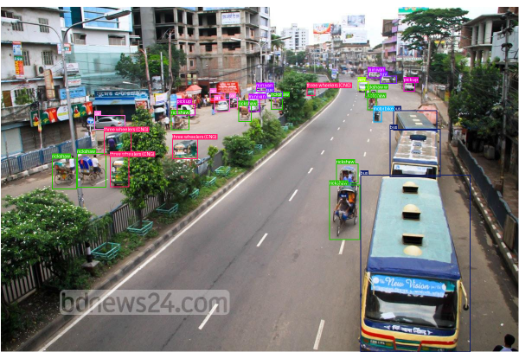

If everything looks good, we'll introduce some transformations.  The first one will be a horizontal flip.  Many everyday objects have bilateral symmetry (or nearly so), so a flipped image will still have the same object classes in it.  This makes a horizontal flip a good data augmentation transformation.

(In contrast, up/down symmetry is less common.  A vertical flip is generally not as useful, unless you need to recognize upside-down objects.)

The transforms version 2 module has a `RandomHorizontalFlip` transformation.  This takes the probability of a flip as an argument.

**Task 3.5.17:** Use the `RandomHorizontalFlip` transformation to flip the sample image.  Set `p=1` to ensure that the flip happens.

In [ ]:
flipped = v2.RandomHorizontalFlip(p=1)(sample_torch)

plot_with_bboxes(flipped, bboxes_tv, classes)

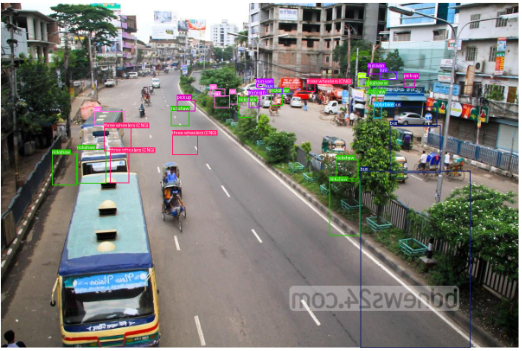

The image has flipped, but the bounding boxes are still in their original locations.  Note that the bus is now in the bottom left of the image.  Its bounding box is still at the bottom right, and it now contains some asphalt, planters and trees.  If we fed this into a model, it would make the model worse, by confusing it as to what a bus looks like.

So, we need to transform the bounding box coordinates consistent with the image transformation.  The Torchvision version 2 transformations can take multiple arguments. They perform the same transformation on all of the arguments, returning a transformed version of each.  They also understand how to correctly transform the `BoundingBoxes` tensors, depending on their type.

**Task 3.5.18:** Use `RandomHorizontalFlip` to flip both the sample image and its bounding boxes.  Check that they line up correctly now.

In [ ]:
flipped, flipped_bboxes =v2.RandomHorizontalFlip(p=1)(sample_torch, bboxes_tv)

plot_with_bboxes(flipped, flipped_bboxes, classes)

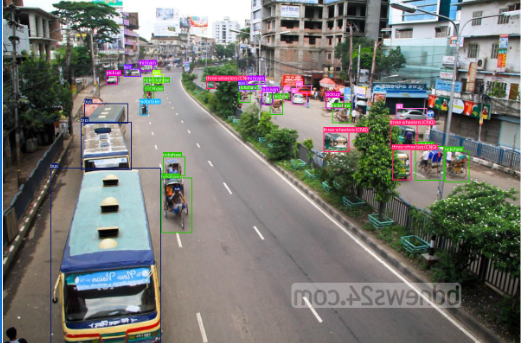

**Task 3.5.19:** Apply the `RandomRotation` transformation.  This takes an argument of the maximum number of degrees to rotate the image.  Set it to 90.

In [ ]:
rotated, rotated_bboxes = v2.RandomRotation(90)(sample_torch, bboxes_tv)

plot_with_bboxes(rotated, rotated_bboxes, classes)

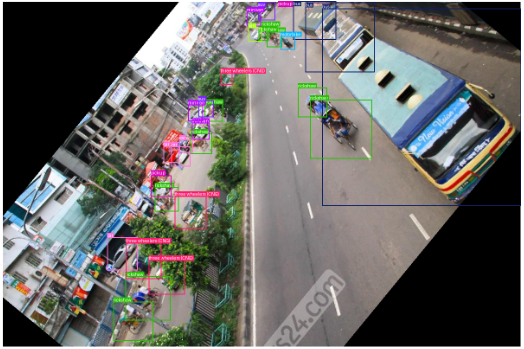

Multiple augmentation techniques can be chained together to produce even more diversity in the training images.  Within Torchvision, this can be accomplished by the `Compose` element.

**Task 3.5.20:** Create an augmentation pipeline that combines the `RandomHorizontalFlip` with the `RandomRotation`.  This time, set the probability of the flip to 50%.

In [ ]:
transforms = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=90)
    ]
)

transformed, transformed_bboxes = transforms(sample_torch, bboxes_tv)

plot_with_bboxes(transformed, transformed_bboxes, classes)

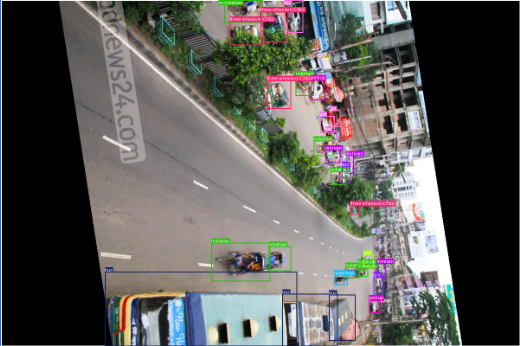

There are a large number of transformations that can be used for data augmentation.  Scroll through [the documentation](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended) to get a view of the range of possibilities.

In addition to the transforms we've already used, note:
- [`RandomResizedCrop`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomResizedCrop.html#torchvision.transforms.v2.RandomResizedCrop) will randomly crop the image down, and then it resizes the output to a set dimension.
- [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ColorJitter.html#torchvision.transforms.v2.ColorJitter) can randomly adjust the brightness, contrast, saturation, and hue of the image, within specified ranges.

**Task 3.5.21:** Create an augmentation pipeline that applies several of these transformations.  Choose reasonable values for the parameters.  Check that the bounding boxes are transformed correctly through this.

In [ ]:
transforms = v2.Compose(
    [
        v2.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
        v2.ColorJitter(brightness=0.5),
        v2.RandomRotation(degrees=90)
    ]
)

transformed, transformed_bboxes = transforms(sample_torch, bboxes_tv)
plot_with_bboxes(transformed, transformed_bboxes, classes)

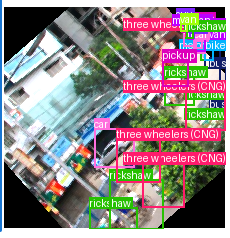

You can run the transformation several times to see the different types of images that result.  This greater diversity of training images will help models learn to generalize instead of memorizing during training.

# **Conclusion**

You've now seen data augmentation in practice for object detection tasks. By increasing the diversity of training images, data augmentation enhances a model's ability to generalize. This will increase their performance on unseen data, which is the ultimate goal of a machine learning system. In this process, we've learned: - How to get the data loader from a YOLO model. - The augmentation transforms that YOLO applies by default. - The Torchvision transforms to use for data augmentation. - Why both the images and the labels need to be transformed together. - How to compose several augmentation techniques.

When you are using pre-trained models like YOLO, you may not need to know all of these details. The default settings are pretty good, so you should probably leave them as-is at first. Adjust them only when you find a need for it. However, when you're working at a lower level on custom models, data augmentation will be up to you. Consider adding it to improve the performance of your model.